# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [16]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [17]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

### Variables

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning)
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [19]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['AA', 'AAT', 'ABM', 'ABR', 'ABT', 'ACI', 'ACM', 'ACRE', 'ADC',
       'ADM', 'ADT', 'AEM', 'AEO', 'AEP', 'AER', 'AES', 'AFG', 'AG',
       'AGCO', 'AGM', 'AGM-A', 'AGO', 'AGRO', 'AHH', 'AHT', 'AHT-PD',
       'AIG', 'AIN', 'AIT', 'AIV', 'AIZ', 'AJG', 'AKR', 'AL', 'ALE',
       'ALEX', 'ALK', 'ALL', 'ALSN', 'ALV', 'ALX', 'AM', 'AMD', 'AMG',
       'AMP', 'AMRC', 'AMT', 'AN', 'ANF', 'AON', 'AP', 'APA', 'APAM',
       'APD', 'APH', 'APO', 'ARE', 'ARL', 'ARR', 'ARW', 'ASGN', 'ASH',
       'ASR', 'ATI', 'AU', 'AVA', 'AVB', 'AVD', 'AVT', 'AVY', 'AWH',
       'AWI', 'AWK', 'AXL', 'AXP', 'AXS', 'AYI', 'AZO', 'AZZ', 'BCC',
       'BCE', 'BCH', 'BCO', 'BDC', 'BDN', 'BDX', 'BEAM', 'BEN', 'BEP',
       'BFAM', 'BFS', 'BG', 'BGC', 'BH', 'BHE', 'BHLB', 'BIO', 'BIP',
       'BK', 'BKD', 'BKE', 'BKH', 'BMI', 'BMY', 'BOH', 'BRC', 'BRFS',
       'BRO', 'BRT', 'BSAC', 'BSBR', 'BSX', 'BTE', 'BTU', 'BWA', 'BXC',
       'BXMT', 'BXP', 'BYD', 'BZH', 'C', 'CAH', 'CALX', 'CBT', 'CBU',
       'CCI', 'CCJ

In [20]:
symbol = "ENG"
ticker = yf.Ticker(symbol)

earning_dates = ticker.cash_flow.columns.tolist()
display(earning_dates)

if len(earning_dates) == 5:
    earning_dates.remove(earning_dates[4])
    print(earning_dates)

cash_flow = ticker.cash_flow
display(cash_flow)

balance_sheet = ticker.balance_sheet
display(balance_sheet)

income_statement = ticker.income_stmt
display(income_statement)


[Timestamp('2023-12-31 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2020-12-31 00:00:00')]

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Free Cash Flow,-5005000.0,-15138000.0,-13904000.0,-947000.0
Repurchase Of Capital Stock,NaN,NaN,NaN,0.0
Repayment Of Debt,-1898000.0,-224000.0,-129000.0,-93000.0
Issuance Of Debt,1047000.0,625000.0,0.0,4949000.0
Issuance Of Capital Stock,2962000.0,0.0,19984000.0,0.0
Capital Expenditure,-174000.0,-602000.0,-240000.0,-428000.0
Interest Paid Supplemental Data,219000.0,223000.0,212000.0,153000.0
Income Tax Paid Supplemental Data,57000.0,52000.0,151000.0,86000.0
End Cash Position,615000.0,3464000.0,19202000.0,13706000.0
Beginning Cash Position,3464000.0,19202000.0,13706000.0,8307000.0


,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Ordinary Shares Number,5156583.0,4475077.0,4403834.0,3445085.0
Share Issued,5156583.0,4475077.0,4403834.0,3445085.0
Net Debt,432000.0,NaN,NaN,NaN
Total Debt,9345000.0,10727000.0,6436000.0,8589000.0
Tangible Book Value,-2275000.0,9605000.0,27471000.0,12903000.0
...,...,...,...,...
Notes Receivable,NaN,NaN,NaN,0.0
Accounts Receivable,10106000.0,9154000.0,8498000.0,6720000.0
Cash Cash Equivalents And Short Term Investments,615000.0,3464000.0,19202000.0,13706000.0
Cash And Cash Equivalents,615000.0,3464000.0,19202000.0,13706000.0


,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.21,0.21,0.27,0.27
Normalized EBITDA,-13897000.0,-17319000.0,-4852000.0,80000.0
Net Income From Continuing Operation Net Minority Interest,-15153000.0,-18514000.0,-5685000.0,-625000.0
Reconciled Depreciation,933000.0,933000.0,561000.0,449000.0
Reconciled Cost Of Revenue,39402000.0,44401000.0,37053000.0,55998000.0
EBITDA,-13897000.0,-17319000.0,-4852000.0,80000.0
EBIT,-14830000.0,-18252000.0,-5413000.0,-369000.0
Net Interest Income,-219000.0,-223000.0,-212000.0,-153000.0
Interest Expense,219000.0,223000.0,212000.0,153000.0


#### Download annual financial data

In [21]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
                    print(error)
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [22]:
if debugging:
    display(df)

### Impution and encoding

In [23]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [24]:
pred_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    train_data = pd.concat([train_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print('Train and Test Data:')
    display(train_data)

### Labeling

In [25]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    display(X_train)
    display(y_train)
    display(X_test)
    display(y_test)

## Model Training

In [26]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        n_iter_no_change=10
    )
    model.fit(X_train, y_train)

Iteration 1, loss = 180.34535813
Validation score: -14.829395
Iteration 2, loss = 0.52735928
Validation score: -2.576326
Iteration 3, loss = 0.32164619
Validation score: -1.930932
Iteration 4, loss = 0.18341495
Validation score: -2.373606
Iteration 5, loss = 0.09232948
Validation score: -0.872953
Iteration 6, loss = 0.06270191
Validation score: -0.522197
Iteration 7, loss = 0.05535797
Validation score: -1.350303
Iteration 8, loss = 0.05557387
Validation score: -0.330808
Iteration 9, loss = 0.05691611
Validation score: -0.073349
Iteration 10, loss = 0.04916459
Validation score: -0.362144
Iteration 11, loss = 0.06182977
Validation score: -0.433360
Iteration 12, loss = 0.05702860
Validation score: -0.138789
Iteration 13, loss = 0.04697521
Validation score: -0.706767
Iteration 14, loss = 0.06824898
Validation score: -0.577462
Iteration 15, loss = 0.05275226
Validation score: -1.156221
Iteration 16, loss = 0.05407590
Validation score: -0.146927
Iteration 17, loss = 0.06063743
Validation sco

## Testing and benchmarking

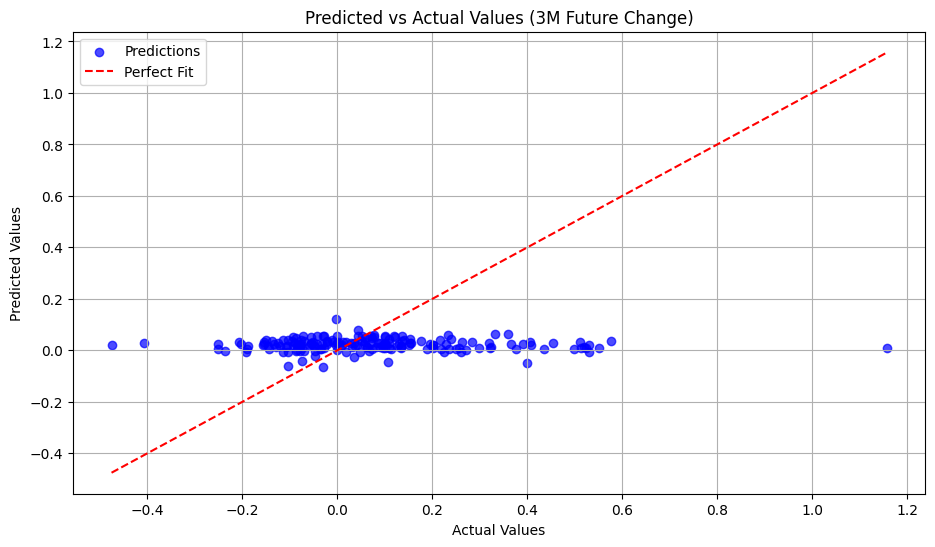

3M Future Change - R²: -0.0795
3M Future Change - MSE: 0.0463
3M Future Change - MAE: 0.1534


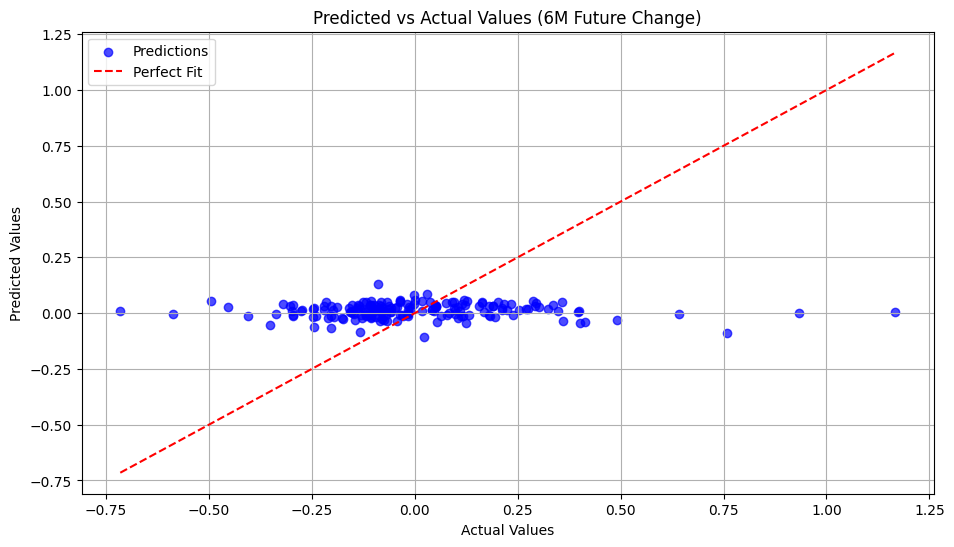

6M Future Change - R²: -0.0247
6M Future Change - MSE: 0.0581
6M Future Change - MAE: 0.1757


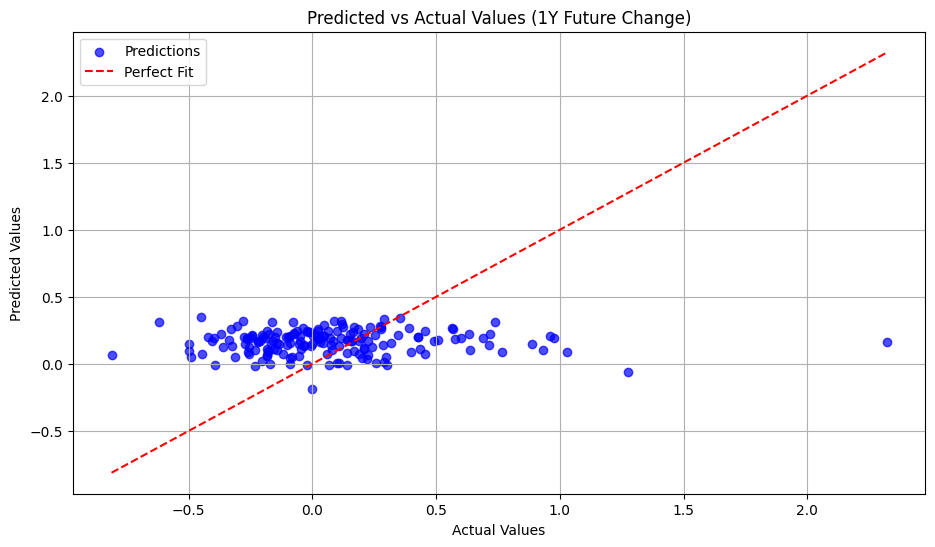

1Y Future Change - R²: -0.1140
1Y Future Change - MSE: 0.1557
1Y Future Change - MAE: 0.2997

Overall Scores:
Mean - R²: -0.0727
Mean - MSE: 0.0867
Mean - MAE: 0.2096


In [27]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [28]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [29]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0677521342220023


In [30]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Dividends Received Direct
Feature names seen at fit time, yet now missing:
- Depletion Income Statement
- Dividends Paid Direct


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://649c32b2904cefe078.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
